This tutorial uses deep learning to compose one image in the style of another one, such technique is known as neural style transfer.

The neural style transfer is an optimizer technique that takes two images - one is the content image and the other is the style reference that is usually a artwork by a famous painter - and blend them together. These operations make the output look like the content image but it is painted in the style of the reference image.

This is implemented by optimizing the output image to match the content statistics of the content image and to match the style statistics of the reference image. Such statistics works are collected by the convolutional neural network.

This tutorial demonstrates the origin neural style transfer. Modern approaches are directly training a model to generate the stylized image, such as CycleGAN, etc.

The following is a simple example. (refer to Tensorflow.org(2020) and Wassily Kandinsky's Composition 7)

| Content Image | Style Reference | Output Image |
| -- | -- | -- |
| ![](https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg) | ![](https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg) | ![](https://tensorflow.org/tutorials/generative/images/stylized-image.png) |

In [0]:
!pip uninstall -y tensorflow
!pip install -q --no-cache-dir tf-nightly

In [1]:
import tensorflow as tf
import IPython.display as display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import functools

print("Tensorflow Version: {}".format(tf.__version__))
print("GPU {} available.".format("is" if tf.config.experimental.list_physical_devices("GPU") else "not"))

Tensorflow Version: 2.2.0-dev20200405
GPU is available.


In [0]:
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

# Data Preprocessing

Define a helper function to convert a normalized tensor to an image.

In [0]:
def tensor_to_image(tensor):
  """
  Args:
    tensor: an normalized (from 0.0 to 1.0) image in the shape of (batch_size==1, height, width, 3).
  """
  tensor = tensor * 255
  tensor = np.array(tensor, np.uint8)
  if tensor.ndim > 3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

Download the content image and the style reference image.

In [4]:
content_path = tf.keras.utils.get_file(fname='YellowLabradorLooking_new.jpg', 
                                       origin='https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
print("Content image path: {}".format(content_path))

style_path = tf.keras.utils.get_file(fname='kandinsky5.jpg',
                                     origin='https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')
print("Style image path: {}".format(style_path))

90112/83281 [================================] - 0s 0us/step
Content image path: /root/.keras/datasets/YellowLabradorLooking_new.jpg
196608/195196 [==============================] - 0s 0us/step
Style image path: /root/.keras/datasets/kandinsky5.jpg


## Visualize the Input

In [0]:
def load_img(img_path):
  max_shape = 512

  # read the image
  img = tf.io.read_file(filename=img_path)
  img = tf.image.decode_image(contents=img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  # scale to the max_shape
  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  scaled = max_shape / max(shape)
  new_shape = tf.cast(shape * scaled, tf.int32)

  # resize the image
  new_img = tf.image.resize(images=img, size=new_shape)
  new_img = new_img[tf.newaxis, ...]
  return new_img

In [0]:
def imshow(content, title=None):
  if len(content.shape) > 3:
    content = tf.squeeze(content, axis=0)

  plt.imshow(content)
  if title:
    plt.title(title)
  plt.axis("off")

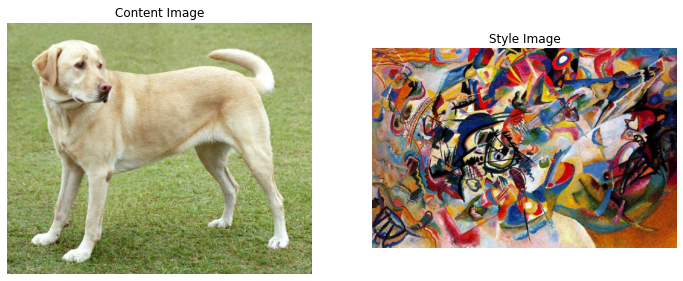

In [7]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, title="Content Image")

plt.subplot(1, 2, 2)
imshow(style_image, title="Style Image")

# Fast Style Transfer using TF-Hub

Before getting into more details about the style transfer, let's see the example using the TF.hub model.

In [0]:
import tensorflow_hub as hub

In [0]:
hub_module = hub.load(handle='https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/1')

In [10]:
stylied_image = hub_module(tf.constant(content_image), tf.constant(style_image))
stylied_image[0].shape

TensorShape([1, 424, 512, 3])

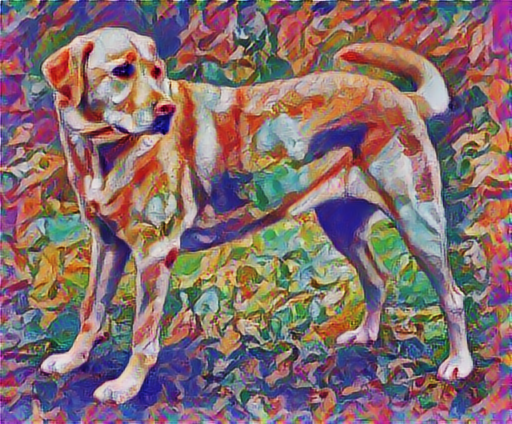

In [11]:
tensor_to_image(stylied_image[0])

# Build a Model

## Define content and style representations

Let's start a pre-trained VGG19 model to extract the representations. Such an operation is like transfer learning, the lower layer in the VGG19 model represents low-level features that are like edges, textures. On the contrary, the higher layer represents high-level features that are like eyes, wheels, etc. Here we start to build a model using the intermediate layers in the VGG model. 

Let's try an inference over a pre-trained VGG19 model.

In [12]:
x = tf.keras.applications.vgg19.preprocess_input(x=content_image*255)
x = tf.image.resize(x, size=(224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')

574717952/574710816 [==============================] - 3s 0us/step


In [13]:
predict_probabilities = vgg(x)
predict_probabilities.shape

TensorShape([1, 1000])

In [14]:
predicted_top_10 = tf.keras.applications.vgg19.decode_predictions(
  preds=predict_probabilities.numpy(), top=10)

40960/35363 [==================================] - 0s 0us/step


In [15]:
for number, class_name, prob in predicted_top_10[0]:
  print(number, class_name, prob)

n02099712 Labrador_retriever 0.49317113
n02099601 golden_retriever 0.23665294
n02104029 kuvasz 0.03635755
n02099849 Chesapeake_Bay_retriever 0.024182769
n02107574 Greater_Swiss_Mountain_dog 0.018646104
n02088466 bloodhound 0.0135872485
n02090379 redbone 0.012214597
n02089867 Walker_hound 0.012085043
n02089973 English_foxhound 0.010630123
n02091831 Saluki 0.01004253


Now load the VGG19 model without the final classification layer.

In [16]:
vgg = tf.keras.applications.VGG19(include_top=False, weights="imagenet")

80142336/80134624 [==============================] - 2s 0us/step


In [17]:
vgg.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [18]:
print("VGG19 Model Layers")
for layer in vgg.layers:
  print("{:15s}: {}".format(layer.name, layer.input.shape))

VGG19 Model Layers
input_2        : (None, None, None, 3)
block1_conv1   : (None, None, None, 3)
block1_conv2   : (None, None, None, 64)
block1_pool    : (None, None, None, 64)
block2_conv1   : (None, None, None, 64)
block2_conv2   : (None, None, None, 128)
block2_pool    : (None, None, None, 128)
block3_conv1   : (None, None, None, 128)
block3_conv2   : (None, None, None, 256)
block3_conv3   : (None, None, None, 256)
block3_conv4   : (None, None, None, 256)
block3_pool    : (None, None, None, 256)
block4_conv1   : (None, None, None, 256)
block4_conv2   : (None, None, None, 512)
block4_conv3   : (None, None, None, 512)
block4_conv4   : (None, None, None, 512)
block4_pool    : (None, None, None, 512)
block5_conv1   : (None, None, None, 512)
block5_conv2   : (None, None, None, 512)
block5_conv3   : (None, None, None, 512)
block5_conv4   : (None, None, None, 512)
block5_pool    : (None, None, None, 512)


Choose intermediate layers from the network to represent the style and the content of the image.

In [0]:
# content layer will pull the feature maps
content_layers = ['block5_conv2']
num_content_layers = len(content_layers)

# style layer of the interest
style_layers = ['block1_conv1', 
                'block2_conv1', 
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']
num_style_layers = len(style_layers)

## Model Body

In [0]:
def vgg_layers(layer_names):
  """
  Args:
    layer_names: a list of each output layers
  """
  vgg = tf.keras.applications.VGG19(include_top=False, weights="imagenet")
  vgg.trainable = False

  outputs = [vgg.get_layer(layer).output for layer in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

Create the model.

In [21]:
style_extractor = vgg_layers(style_layers)
style_output = style_extractor(style_image * 255)

# look the statistics of each layer's outputs
for layer_name, output in zip(style_layers, style_output):
  print(layer_name)
  print("Shape: {}".format(output.numpy().shape))
  print("Min: {}".format(output.numpy().min()))
  print("Max: {}".format(output.numpy().max()))
  print("Mean: {}".format(output.numpy().mean()))
  print()

block1_conv1
Shape: (1, 336, 512, 64)
Min: 0.0
Max: 835.5255737304688
Mean: 33.975250244140625

block2_conv1
Shape: (1, 168, 256, 128)
Min: 0.0
Max: 4625.8857421875
Mean: 199.82687377929688

block3_conv1
Shape: (1, 84, 128, 256)
Min: 0.0
Max: 8789.2392578125
Mean: 230.78099060058594

block4_conv1
Shape: (1, 42, 64, 512)
Min: 0.0
Max: 21566.134765625
Mean: 791.2400512695312

block5_conv1
Shape: (1, 21, 32, 512)
Min: 0.0
Max: 3189.254150390625
Mean: 59.17947769165039



## Extract Style and Content

### Calculate Style

The content of an image is represented by the values of the intermediate feature maps. The style of an image can be described by the means and the correlations across the different feature maps. Calculate a Gram Matrix that includes this information by taking the outer product of the feature vector with itself at each location, and averaging that outer product over all locations.

$$G^{l}_{cd}=\frac{\sum_{ij}F^{l}_{ijc}(x)F^{l}_{ijd}(x)}{IJ}$$

In [0]:
def gram_matrix(input_tensor):
  # matrix multiplication on the batch data
  result = tf.linalg.einsum("bijc,bijd->bcd", input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result / num_locations

Build a model that calculates the style and the content tensors.

In [0]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()

    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)

    self.vgg = vgg_layers(style_layers + content_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    """
    Args:
      inputs: a batch of images that are normalized in [0,1]
    """
    inputs = inputs * 255.0
    model_inputs = tf.keras.applications.vgg19.preprocess_input(x=inputs)
    model_outputs = self.vgg(model_inputs)

    style_outputs, content_outputs = model_outputs[:self.num_style_layers], \
                                     model_outputs[self.num_style_layers:]

    # calculate gram matrix
    style_outputs = [gram_matrix(output) for output in style_outputs]

    # put the output in the dictionaries
    style_dict = {}
    for style_name, style_gram_output in zip(self.style_layers, style_outputs):
      style_dict[style_name] = style_gram_output

    content_dict = {}
    for content_name, content_output in zip(self.content_layers, content_outputs):
      content_dict[content_name] = content_output

    return {'style': style_dict, 'content': content_dict}

Let's try the style and the content extractor.

In [24]:
style_layers, content_layers, tf.constant(content_image).shape

(['block1_conv1',
  'block2_conv1',
  'block3_conv1',
  'block4_conv1',
  'block5_conv1'],
 ['block5_conv2'],
 TensorShape([1, 422, 512, 3]))

In [0]:
extractor = StyleContentModel(style_layers, content_layers)
results = extractor(tf.constant(content_image))

In [26]:
print("Style")
for name, output in sorted(results["style"].items()):
  print("  ", name)
  print("   shape: ", output.numpy().shape)
  print("   max: ", output.numpy().max())
  print("   min: ", output.numpy().min())
  print("   mean: ", output.numpy().mean())
  print()

print("Content")
for name, output in sorted(results["content"].items()):
  print("  ", name)
  print("   shape: ", output.numpy().shape)
  print("   max: ", output.numpy().max())
  print("   min: ", output.numpy().min())
  print("   mean: ", output.numpy().mean())
  print()

Style
   block1_conv1
   shape:  (1, 64, 64)
   max:  28014.557
   min:  0.0055228444
   mean:  263.79025

   block2_conv1
   shape:  (1, 128, 128)
   max:  61479.473
   min:  0.0
   mean:  9100.949

   block3_conv1
   shape:  (1, 256, 256)
   max:  545623.44
   min:  0.0
   mean:  7660.976

   block4_conv1
   shape:  (1, 512, 512)
   max:  4320501.5
   min:  0.0
   mean:  134288.84

   block5_conv1
   shape:  (1, 512, 512)
   max:  110005.37
   min:  0.0
   mean:  1487.0378

Content
   block5_conv2
   shape:  (1, 26, 32, 512)
   max:  2410.8796
   min:  0.0
   mean:  13.764149



## Run gradient descent

With the style and content extractor, you now can implement the style transfer algorithm. **Do this by calculating the mean square error for image outputs relative to each target, then take the weighted sum of these losses.**

Set your style and content target values.

In [0]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [33]:
style_targets.keys(), content_targets.keys()

(dict_keys(['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']),
 dict_keys(['block5_conv2']))

Define a `tf.Variable` to contain the image to optimize. To make it quick, initialize it with the content image.

In [0]:
image = tf.Variable(initial_value=content_image)

Since this is a float image, define a function to keep the pixel values between 0 and 1.

In [0]:
def clip_0_1(image):
  return tf.clip_by_value(t=image, clip_value_min=0.0, clip_value_max=1.0)

Create an optimizer.

In [0]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

Use a weighted combination of two losses to get the total loss.

In [0]:
style_weight = 1e-2
content_weight = 1e4

In [0]:
def style_content_loss(outputs):
  style_outputs = outputs['style']
  content_outputs = outputs['content']

  style_loss = tf.add_n(
      [tf.reduce_mean((style_outputs[name] - style_targets[name]) ** 2.0) for name in style_outputs.keys()])
  style_loss *= style_weight / num_style_layers

  content_loss = tf.add_n(
      [tf.reduce_mean((content_outputs[name] - content_targets[name]) ** 2.0) for name in content_outputs.keys()])
  content_loss *= content_weight / num_content_layers

  loss = style_loss + content_loss
  return loss

Next, we are going to optimize the variable. Unlike the other algorithm, the optimized target is a variable whose value is initialized from the image. On the other words, you are going to optimize an image which is represented as a variable.

In [0]:
@tf.function
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
  
  grads = tape.gradient(loss, image)
  opt.apply_gradients([(grads, image)])
  image.assign(value=clip_0_1(image))

Next run a few steps to test.

In [0]:
for _ in range(0, 3, 1):
  train_step(image) 

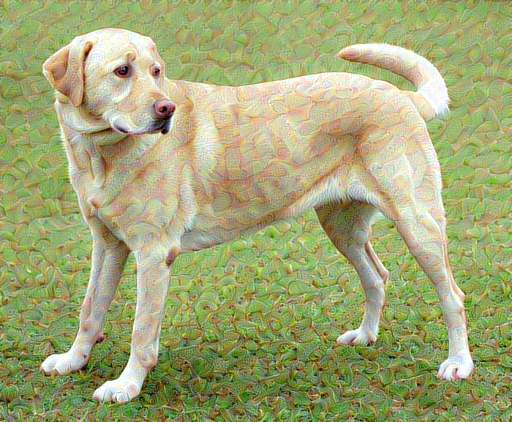

In [53]:
tensor_to_image(image)

After testing the flow is working, let's perform a longer optimization.

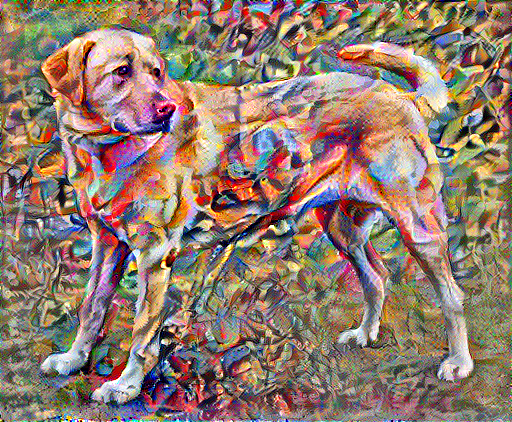

Train Step: 1000


In [54]:
epochs = 10
steps_per_epoch = 100

step = 0
for epoch in range(epochs):
  for steps in range(steps_per_epoch):
    step += 1
    train_step(image)
    print('.', end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(tensor=image))
  print('Train Step: {}'.format(step))

## Total Variation Loss

One downside to this basic implementations is that it produces a lot of high-frequency artifacts. Decrease these using an explicit regularization term on the high-frequency components of the image. This is also called **total variation loss**.

In [0]:
def high_pass_x_y(image):
  x_var = image[:,:,1:,:] - image[:,:,:-1,:]
  y_var = image[:,1:,:,:] - image[:,:-1,:,:]
  return x_var, y_var

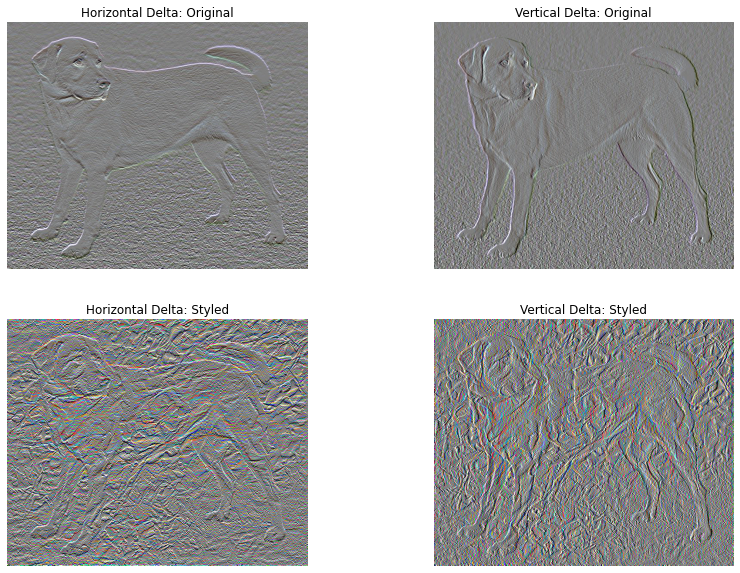

In [57]:
plt.figure(figsize=(14, 10))

# the origin image
x_delta, y_delta = high_pass_x_y(content_image)
plt.subplot(2,2,1)
imshow(content=clip_0_1(2*y_delta + 0.5), title="Horizontal Delta: Original")

plt.subplot(2,2,2)
imshow(content=clip_0_1(2*x_delta + 0.5), title="Vertical Delta: Original")

# the styled image
x_delta, y_delta = high_pass_x_y(image)
plt.subplot(2,2,3)
imshow(content=clip_0_1(2*y_delta + 0.5), title="Horizontal Delta: Styled")

plt.subplot(2,2,4)
imshow(content=clip_0_1(2*x_delta + 0.5), title="Vertical Delta: Styled")

plt.show()

This operation helps to show the high-frequency components have increased. This high-frequency component is an edge-detector. You can get similar output from the Sobel edge detector.

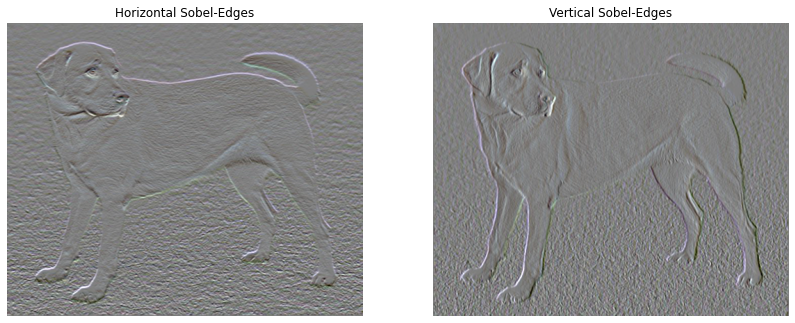

In [58]:
plt.figure(figsize=(14,10))

sobel = tf.image.sobel_edges(image=content_image)
plt.subplot(1,2,1)
imshow(clip_0_1(image=sobel[..., 0] / 4 + 0.5), title="Horizontal Sobel-Edges")
plt.subplot(1,2,2)
imshow(clip_0_1(image=sobel[..., 1] / 4 + 0.5), title="Vertical Sobel-Edges")

plt.show()

The regularization loss associated with these is the sum of the mean absolute error of the values.

In [0]:
def total_variation_loss(image):
  x_delta, y_delta = high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_delta)) + tf.reduce_sum(tf.abs(y_delta))

In [60]:
total_variation_loss(image)

<tf.Tensor: shape=(), dtype=float32, numpy=149273.72>

The above demonstrates how to calculate the loss variation loss. In Tensorflow, an API is implemented to achieve so.

In [61]:
tf.image.total_variation(images=image)

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([149273.72], dtype=float32)>

# Re-run the Optimization

In [0]:
total_variation_weight = 30

In [0]:
@tf.function
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight * tf.image.total_variation(images=image)
  
  grads = tape.gradient(loss, image)
  opt.apply_gradients([(grads, image)])
  image.assign(value=clip_0_1(image))

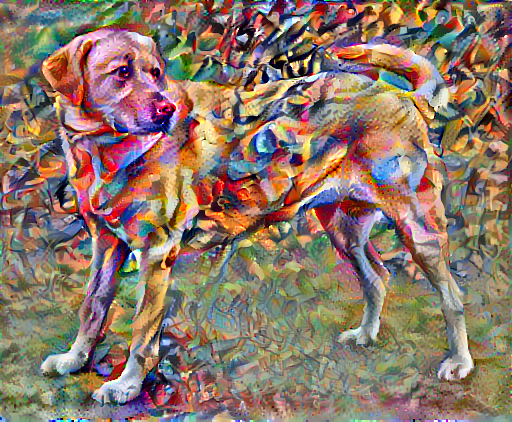

Step: 1000


In [64]:
# initialize the variable
image = tf.Variable(initial_value=content_image)

# run the train step
step = 0
for epoch in range(epochs):
  for steps in range(steps_per_epoch):
    step += 1
    train_step(image)
    print('.', end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Step: {}".format(step))

In [0]:
file_name = "styled_image.png"
tensor_to_image(image).save(file_name)

try:
  from google.colab import files
except:
  pass
else:
  files.download(file_name)